In [2]:
from tools.scrfd import SCRFD
import numpy as np
import os.path as osp
import cv2
import matplotlib.pyplot as plt

In [3]:
MODLE_PATH = "/home/bits/insightface/detection/scrfd_lpr/onnx/scrfd_x00m_bnkps_fast_covid-kit_resnet_shape640x640.onnx"
detector = SCRFD(model_file = MODLE_PATH)

In [4]:
detector.prepare(-1) #cpu run

In [5]:
val_list = "/home/bits/insightface/detection/scrfd_lpr/covid-kit/val.txt"
# val_list = "/home/bits/insightface/detection/scrfd_lpr/covid-kit/train.txt"
val_image_path = []
with open(val_list, "r") as f:
    for line in f.readlines():
        splits = line.split(" ")
        if splits[0] == "#":
            val_image_path.append(splits[1])
print("val images:", len(val_image_path))

val images: 21


In [6]:
def transform_target(img, kps, bbox):
    x1, y1, x2, y2, score = bbox.astype(np.int32)
    xmin = max(0, x1)
    ymin = max(0, y1)
    xmax = min(img.shape[1], x2)
    ymax = min(img.shape[0], y2)
    w = xmax - xmin + 1
    h = ymax - ymin + 1
    img_box = np.zeros((h, w, 3), dtype=np.uint8)
    img_box= img[ymin:ymax+1, xmin:xmax+1, :].copy()
    kps = kps.astype(np.int32)
    new_x1, new_y1 = kps[0][0] - xmin, kps[0][1] - ymin
    new_x2, new_y2 = kps[1][0] - xmin, kps[1][1] - ymin
    new_x3, new_y3 = kps[2][0] - xmin, kps[2][1] - ymin
    new_x4, new_y4 = kps[3][0] - xmin, kps[3][1] - ymin
    points1 = np.float32([[new_x1, new_y1], [new_x2, new_y2], [new_x3, new_y3], [new_x4, new_y4]])
    points2 = np.float32([[0, 0], [16, 0], [16, 96], [0, 96]])
    M = cv2.getPerspectiveTransform(points1, points2)
    dst = cv2.warpPerspective(img_box, M, (16, 96))
    return dst
    

In [7]:
c_line_area = [5,25]
t_line_area = [50,70]
other_area = [35,45]
c_thresh = 40
t_thresh = 15
def hist_anysis(hist):
    c_hist = hist[c_line_area[0]:c_line_area[1]]
    t_hist = hist[t_line_area[0]:t_line_area[1]]
    other_hist = hist[other_area[0]:other_area[1]]
    c_mean = np.mean(c_hist)
    t_mean = np.mean(t_hist)
    other_mean = np.mean(other_hist)
    c_diff = c_mean - other_mean
    t_diff = t_mean - other_mean
    # print("c_diff:", c_diff, "t_diff:", t_diff)
    # print("c_mean:", c_mean, "t_mean:", t_mean, "other_mean:", other_mean)
    if c_diff > c_thresh and t_diff > t_thresh:
        return "Positive"
    elif c_diff > c_thresh and t_diff < t_thresh:
        return "Negative"
    else:
        return "Invalid"
     
    

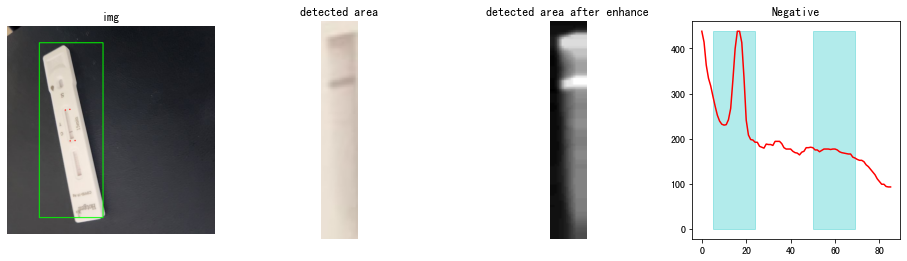

0 Result:  Negative


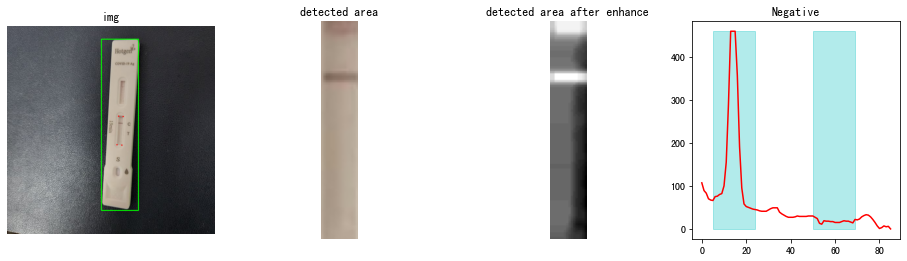

1 Result:  Negative


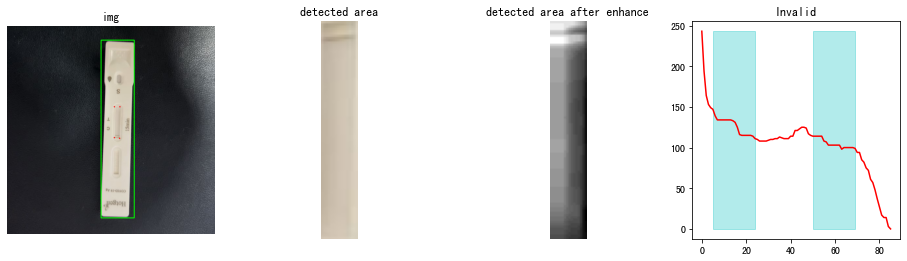

2 Result:  Invalid


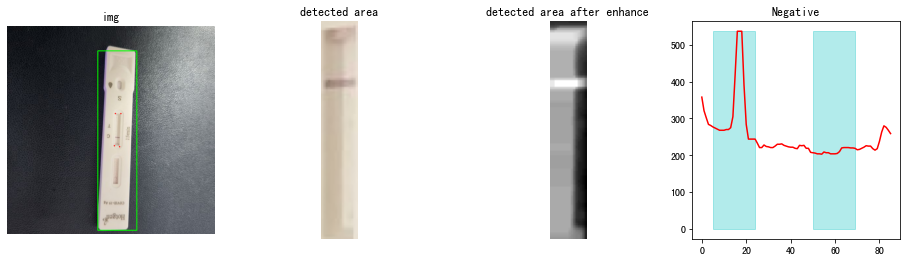

3 Result:  Negative


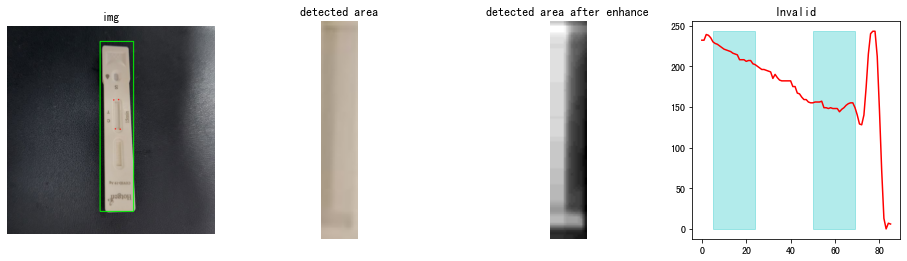

4 Result:  Invalid


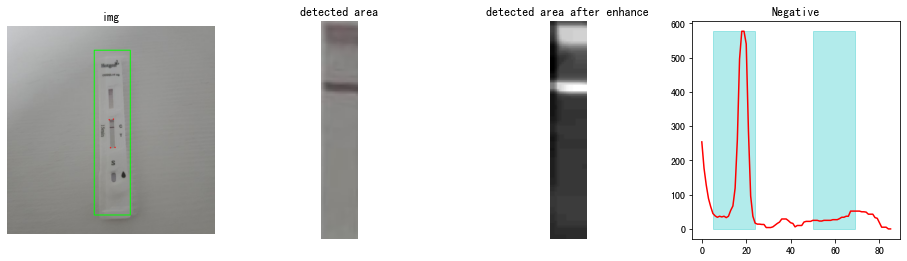

5 Result:  Negative


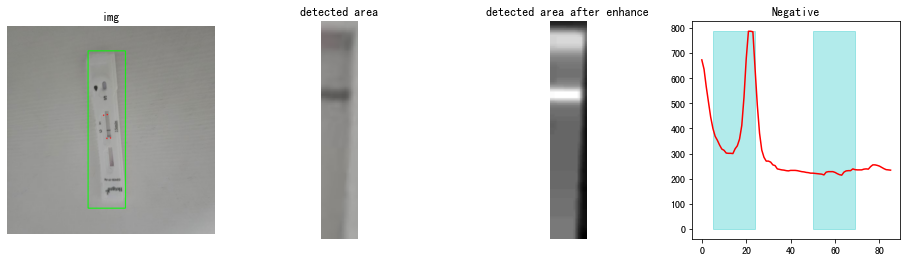

6 Result:  Negative


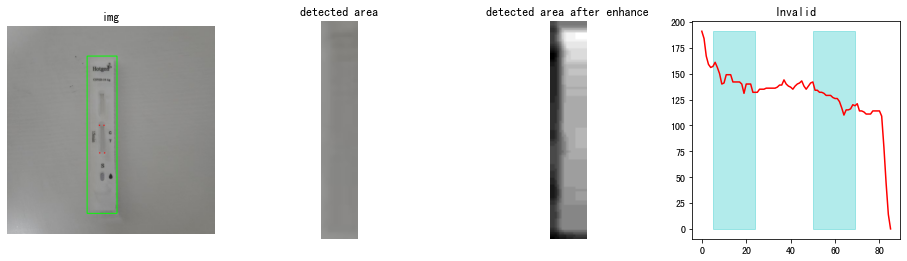

7 Result:  Invalid


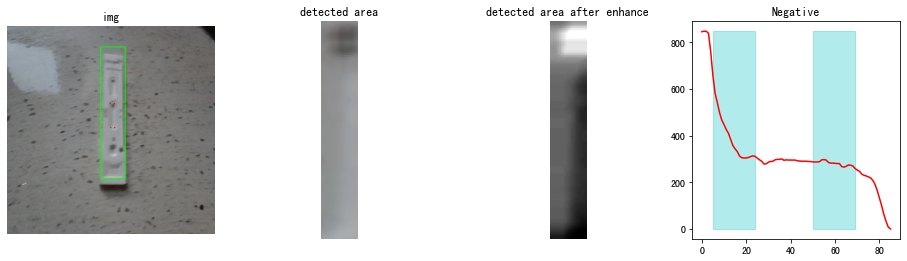

8 Result:  Negative


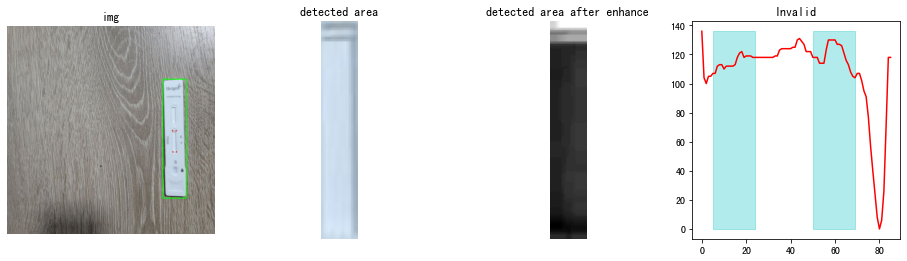

9 Result:  Invalid


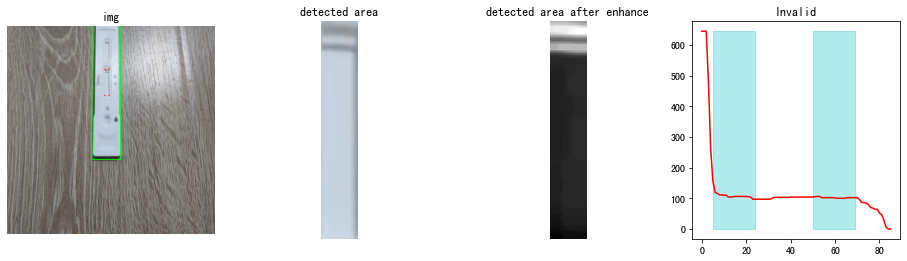

10 Result:  Invalid


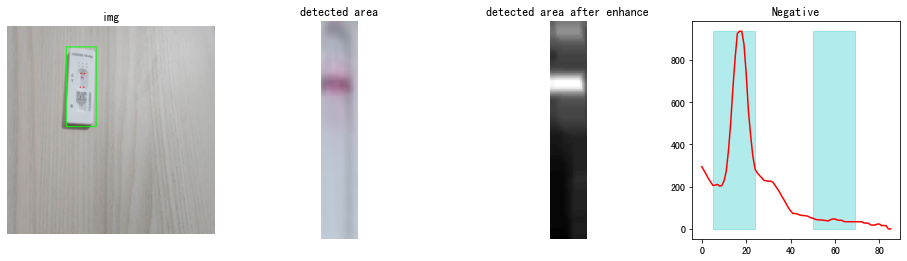

11 Result:  Negative


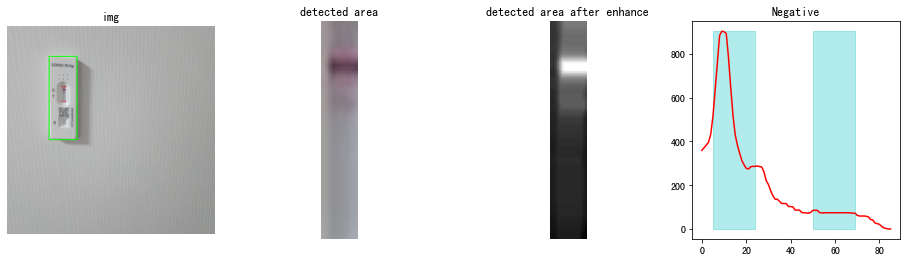

12 Result:  Negative


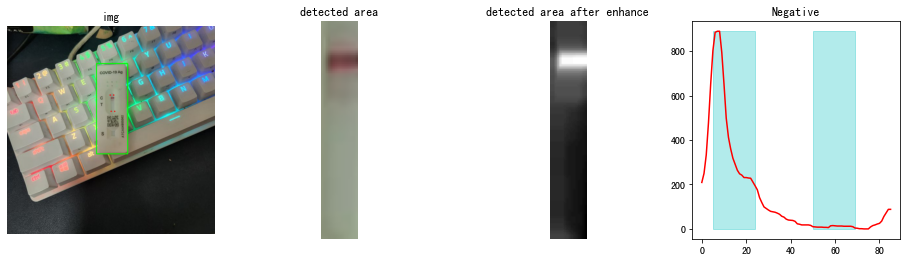

13 Result:  Negative


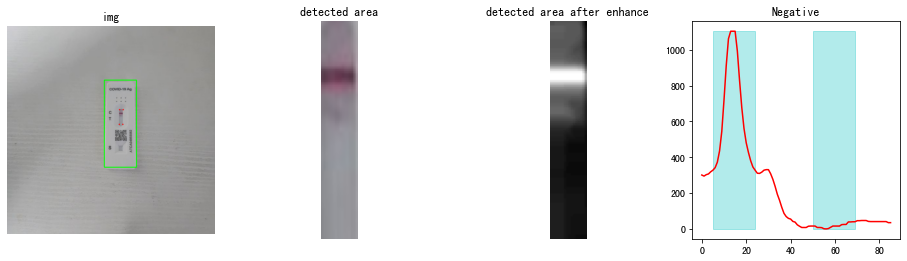

14 Result:  Negative


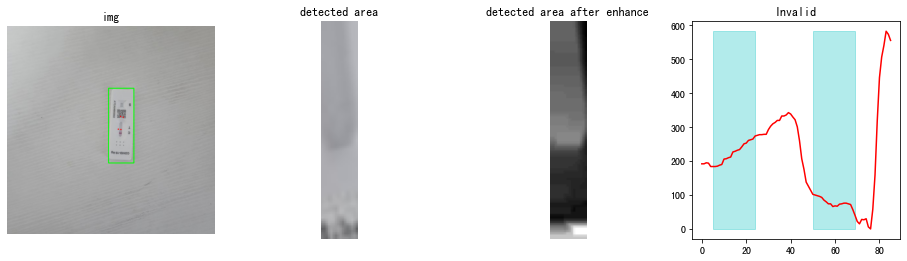

15 Result:  Invalid


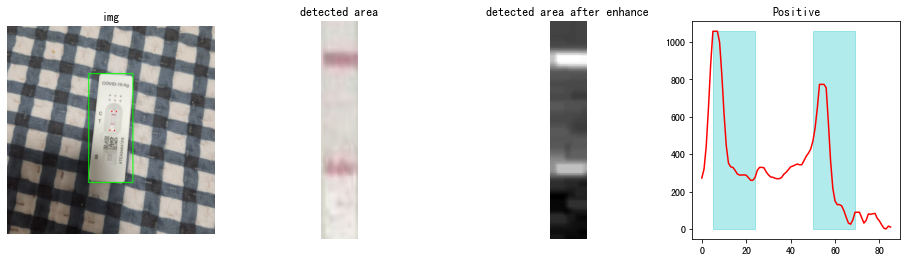

16 Result:  Positive


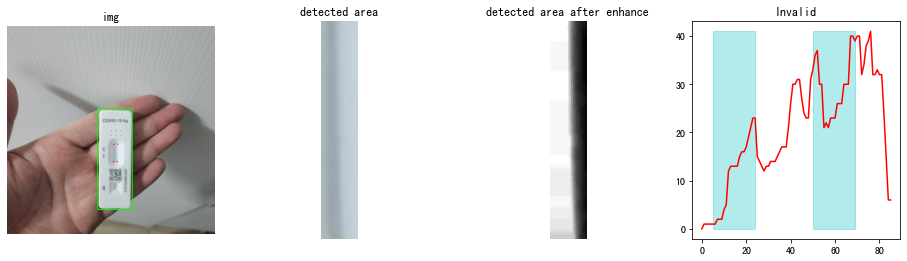

17 Result:  Invalid


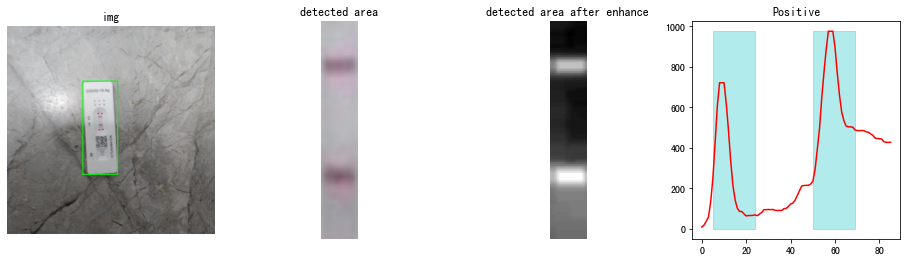

18 Result:  Positive


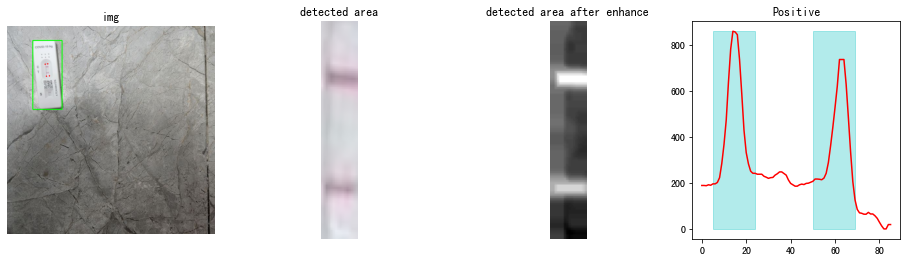

19 Result:  Positive


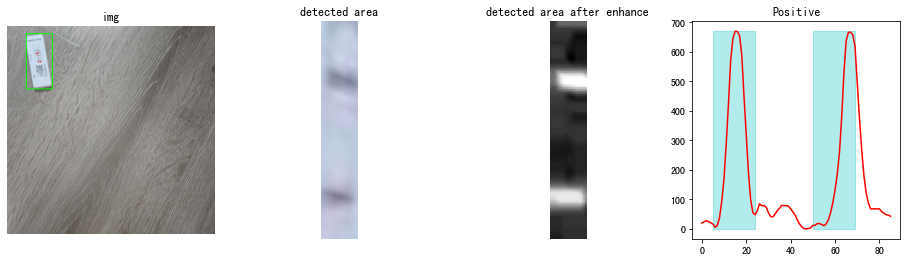

20 Result:  Positive


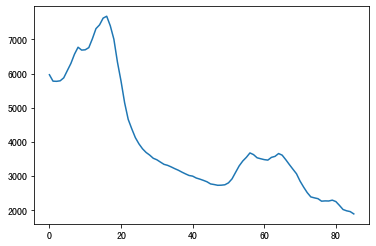

In [8]:
hist_offset =  10
hist_len = 86
hist_sum = np.zeros((hist_len,), dtype=np.float32)
for idx, img_path in enumerate(val_image_path):
    img = cv2.imread(img_path)
    bboxes, kpss = detector.detect(img, 0.5, input_size=(640, 640))
    img_view = img.copy()

    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        x1, y1, x2, y2, score = bbox.astype(np.int32)
        cv2.rectangle(img_view, (x1, y1), (x2, y2), (0, 255, 0), 2)
        if kpss is not None:
            kps = kpss[i]
            for kp in kps:
                kp = kp.astype(np.int32)
                cv2.circle(img_view, (kp[0], kp[1]), 2, (0, 0, 255), -1)
        # plt.imshow(img_view[:, :, ::-1])
        # plt.show()
        processed_img = transform_target(img, kps, bbox)
        # plt.imshow(processed_img[:, :, ::-1])
        # plt.show()
        gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        reverse_gray = 255 - gray
        gray = reverse_gray
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        # _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        # binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
        # plt.imshow(binary, cmap='gray')
        # plt.show()
        # plt.imshow(gray, cmap='gray')
        # plt.show()
        # plt.imshow(reverse_gray, cmap='gray')
        # plt.show()
        # plt.imshow(blur, cmap='gray')
        # plt.show()
        kernel = np.ones((3, 10), dtype=np.uint8)
        # erosion = cv2.erode(binary, kernel, iterations=1)
        # plt.imshow(erosion, cmap='gray')
        # plt.show()
        opening = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel, 3)
        # plt.imshow(opening, cmap='gray')
        # plt.show()

        hist = opening.sum(axis=1)
        hist = hist - hist.min()
        hist = hist[hist_offset:hist_offset+hist_len]
        hist_sum += hist
        # plt.plot(hist)
        # plt.show()

        resutl = hist_anysis(hist)
        #subplot img,processed_img,opening and hist
        plt.figure(figsize=(16, 4))
        plt.subplots_adjust(wspace=0.1)
        plt.subplot(1, 4, 1)
        plt.axis('off')
        plt.imshow(img_view[:, :, ::-1])
        plt.title("img")
        plt.subplot(1, 4, 2)
        plt.axis('off')
        plt.imshow(processed_img[:, :, ::-1])
        plt.title("detected area")
        plt.subplot(1, 4, 3)
        plt.axis('off')
        plt.imshow(opening, cmap='gray')
        plt.title("detected area after enhance")
        plt.subplot(1, 4, 4)
        plt.plot(hist, color='r')
        # plt.plot(hist.mean()*np.ones(hist.shape), color='r')
        # fill red from c_line_area[0] to c_line_area[1]
        hist_max = np.zeros(hist.shape, dtype=np.float32)
        hist_max[:] = hist.max()
        plt.fill_between(range(c_line_area[0], c_line_area[1]), hist_max[c_line_area[0]:c_line_area[1]], color='c', alpha=0.3)
        plt.fill_between(range(t_line_area[0], t_line_area[1]), hist_max[t_line_area[0]:t_line_area[1]], color='c', alpha=0.3)
        plt.title(resutl)
        # plt.savefig(osp.join("/home/bits/insightface/detection/scrfd_lpr/covid-kit/result_output", osp.basename(img_path)), dpi=300)
        plt.show()
        print("{} Result: ".format(idx), resutl)
        # print("val_" + str(idx) + "," + resutl + "," + resutl)
plt.plot(hist_sum)
plt.show()

        



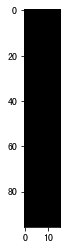

In [28]:
mask = np.zeros((96, 16), dtype=np.uint8)
plt.imshow(mask, cmap='gray')
plt.show()